Training REINFORCE on CartPole-v1 for 2000 episodes...
Hyperparameters: LR=0.005, Gamma=0.995, Hidden Size=256
Episode 50	Average Score: 81.06
Episode 100	Average Score: 94.83
Episode 150	Average Score: 134.92
Episode 200	Average Score: 272.60
Episode 250	Average Score: 438.87
Episode 300	Average Score: 496.28
Episode 350	Average Score: 499.39
Episode 400	Average Score: 416.19
Episode 450	Average Score: 237.11
Episode 500	Average Score: 197.78
Episode 550	Average Score: 364.70
Episode 600	Average Score: 321.91
Episode 650	Average Score: 122.34
Episode 700	Average Score: 79.20
Episode 750	Average Score: 113.47
Episode 800	Average Score: 131.93
Episode 850	Average Score: 116.75
Episode 900	Average Score: 94.46
Episode 950	Average Score: 87.62
Episode 1000	Average Score: 101.82
Episode 1050	Average Score: 92.70
Episode 1100	Average Score: 96.56
Episode 1150	Average Score: 144.14
Episode 1200	Average Score: 169.84
Episode 1250	Average Score: 163.87
Episode 1300	Average Score: 221.70
Episod

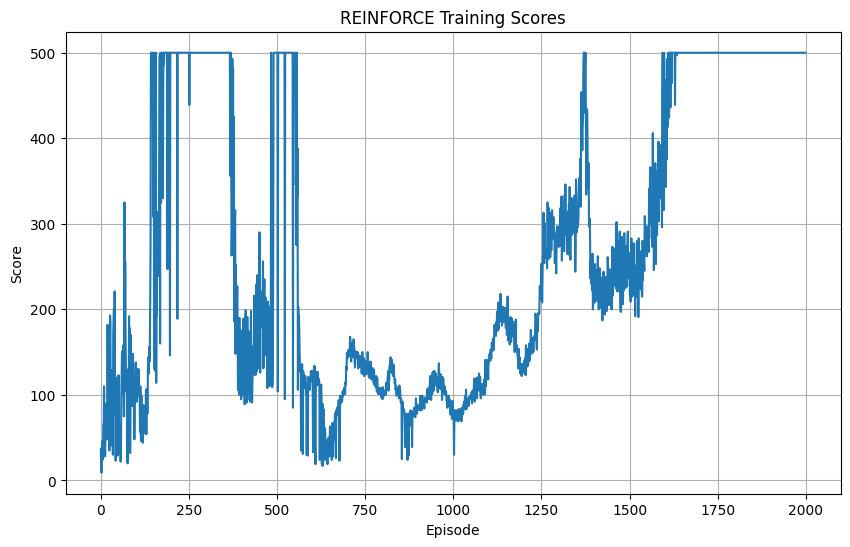

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from collections import deque # For storing rewards for averaging
import matplotlib.pyplot as plt # Import matplotlib for plotting
from torch.optim.lr_scheduler import StepLR # For learning rate scheduling

# 1. Define the Policy Network
# This network will take the state as input and output the probabilities
# of taking each action.
class Policy(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(Policy, self).__init__()
        # Define the layers of the neural network
        self.fc1 = nn.Linear(state_size, hidden_size)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size, action_size) # Output layer for action probabilities

    def forward(self, state):
        # Pass the state through the first layer and apply ReLU activation
        x = F.relu(self.fc1(state))
        # Pass through the second layer to get logits for action probabilities
        action_logits = self.fc2(x)
        # Apply softmax to convert logits into probabilities
        return F.softmax(action_logits, dim=-1)

# 2. Define the REINFORCE Agent
class REINFORCE:
    def __init__(self, state_size, action_size, learning_rate=1e-2, gamma=0.99, hidden_size=128):
        # Initialize the policy network with the given hidden_size
        self.policy = Policy(state_size, action_size, hidden_size=hidden_size)
        # Define the optimizer (Adam is a good choice for policy gradient methods)
        # The learning_rate is crucial; experiment with values like 5e-3, 1e-3, 5e-4.
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        # Discount factor for future rewards (gamma)
        self.gamma = gamma
        # reduce LR by a factor of 0.9 every 100 episodes.
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=0.9)

        # Lists to store log probabilities and rewards for the current episode
        self.log_probs = []  # Stores log probabilities of actions taken
        self.rewards = []    # Stores rewards received at each timestep

    def act(self, state):
        # Convert the state (numpy array) to a PyTorch tensor
        # Add a batch dimension (unsqueeze(0)) because the network expects batch input
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        # Get action probabilities from the policy network
        action_probabilities = self.policy(state_tensor)
        # Create a categorical distribution from the probabilities
        m = torch.distributions.Categorical(action_probabilities)
        # Sample an action from the distribution
        action = m.sample()
        # Store the log probability of the chosen action for later update
        self.log_probs.append(m.log_prob(action))
        # Return the action as a Python integer
        return action.item()

    def store_reward(self, reward):
        # Store the reward received at each step
        self.rewards.append(reward)

    def update_policy(self):
        # Calculate discounted rewards for the entire episode
        discounted_rewards = []
        R = 0 # Initialize cumulative reward
        # Iterate backwards through rewards to calculate discounted returns
        for r in reversed(self.rewards):
            R = r + self.gamma * R  # Calculate discounted return
            discounted_rewards.insert(0, R) # Insert at the beginning to maintain original order

        # Convert discounted rewards to a PyTorch tensor
        discounted_rewards = torch.tensor(discounted_rewards).float()
        # Normalize discounted rewards (optional but often helps stabilize training)
        # Standardize the rewards to have mean 0 and standard deviation 1
        # This helps prevent large gradients and makes training more stable.
        if len(discounted_rewards) > 1: # Avoid division by zero if only one reward
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        # Clear previous gradients
        self.optimizer.zero_grad()

        # Calculate the policy loss
        # The loss is the negative sum of (log_prob * discounted_reward)
        # We negate it because optimizers minimize loss, but we want to maximize returns.
        policy_loss = []
        for log_prob, G in zip(self.log_probs, discounted_rewards):
            policy_loss.append(-log_prob * G)  # Negative because we want to maximize expected return
        policy_loss = torch.cat(policy_loss).sum()  # Sum all losses into a single scalar

        # Perform backpropagation
        policy_loss.backward()
        # Update model parameters
        self.optimizer.step()

        # Step the learning rate scheduler (if defined)
        if self.scheduler:
            self.scheduler.step()

        # Clear the lists for the next episode
        self.log_probs = []
        self.rewards = []

# Main training loop
def train_reinforce(env_name='CartPole-v1', n_episodes=2000, print_every=50,
                    learning_rate=1e-2, gamma=0.99, hidden_size=128): # Added parameters for easy tuning
    # Create the Gymnasium environment
    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]  # Number of state features
    action_size = env.action_space.n             # Number of possible actions

    # Initialize the REINFORCE agent with tunable hyperparameters
    agent = REINFORCE(state_size, action_size, learning_rate, gamma, hidden_size)

    # List to store scores (total rewards) for each episode
    scores_deque = deque(maxlen=100) # Keep track of last 100 scores for averaging
    scores = [] # Store all scores

    print(f"Training REINFORCE on {env_name} for {n_episodes} episodes...")
    print(f"Hyperparameters: LR={learning_rate}, Gamma={gamma}, Hidden Size={hidden_size}")

    # Training loop - run for specified number of episodes
    for i_episode in range(1, n_episodes + 1):
        # Reset the environment at the start of each episode
        state, _ = env.reset()
        episode_reward = 0  # Track total reward for this episode
        done = False
        
        # Interact with the environment until the episode is done
        while not done:
            # Agent selects an action based on current policy
            action = agent.act(state)
            # Environment performs the action and returns next state, reward, etc.
            next_state, reward, done, truncated, _ = env.step(action)
            # Agent stores the reward for policy update
            agent.store_reward(reward)
            # Update the current state for next iteration
            state = next_state
            episode_reward += reward  # Accumulate total episode reward

            # If the episode is done (either terminated or truncated), break the loop
            if done or truncated:
                break

        # After the episode ends, update the policy using REINFORCE algorithm
        agent.update_policy()

        # Store and print scores for monitoring training progress
        scores_deque.append(episode_reward)
        scores.append(episode_reward)
        avg_score = np.mean(scores_deque)  # Calculate moving average

        # Print progress every print_every episodes
        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Score: {avg_score:.2f}')

        # CartPole-v1 is considered solved when the average reward is >= 195.0 over 100 consecutive trials.
        if avg_score >= 1950.0 and len(scores_deque) == 100:
            print(f'\nEnvironment solved in {i_episode} episodes! Average Score: {avg_score:.2f}')
            break

    env.close() # Close the environment to free resources
    return scores  # Return list of all episode scores

# Main execution block - only runs when script is executed directly
if __name__ == '__main__':
    # Hyperparameter tuning - these values can be adjusted for better performance
    tuned_learning_rate = 5e-3  # Learning rate for Adam optimizer
    tuned_gamma = 0.995         # Discount factor for future rewards
    tuned_hidden_size = 256     # Number of neurons in hidden layer

    # Train the agent with tuned hyperparameters
    episode_scores = train_reinforce(
        learning_rate=tuned_learning_rate,
        gamma=tuned_gamma,
        hidden_size=tuned_hidden_size
    )

    # Plotting the scores to visualize training progress
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(episode_scores)), episode_scores)  # Plot episode vs score
    plt.title('REINFORCE Training Scores')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid(True)  # Add grid for better readability
    plt.show()      # Display the plot